In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
plt.rcParams['figure.figsize'] = (15, 10)

In [6]:
x = pd.read_csv('data/x_train.csv.gz', delimiter=';')
y = np.ravel(pd.read_csv('data/y_train.csv.gz', names=['target']))
test = pd.read_csv('data/x_test.csv.gz', delimiter=';')

In [7]:
import xgboost as xgb

In [14]:
clf = xgb.XGBClassifier()
scores = cross_val_score(clf, x, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE: {} (+/- {})".format(scores.mean(), scores.std() * 2))

MAE: -0.17193239735747579 (+/- 0.009582423771181984)


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, np.ravel(y))

In [18]:
clf = xgb.XGBClassifier()
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [22]:
for f, imp in sorted(zip(clf.feature_importances_, x_train.columns), reverse=True):
    print("{}: {}".format(f, imp))

0.1681547611951828: totalNumOfAttempts
0.1666666716337204: numberOfDaysActuallyPlayed
0.1383928507566452: maxPlayerLevel
0.125: totalScore
0.1205357164144516: averageNumOfTurnsPerCompletedLevel
0.0863095223903656: numberOfBoostersUsed
0.0520833320915699: fractionOfUsefullBoosters
0.0416666679084301: totalBonusScore
0.0416666679084301: attemptsOnTheHighestLevel
0.0252976194024086: numberOfAttemptedLevels
0.02083333395421505: doReturnOnLowerLevels
0.013392857275903225: totalStarsCount


In [23]:
pred = clf.predict_proba(x_test)[:,1]
pred

array([ 0.96324271,  0.02453863,  0.52243668, ...,  0.15210983,
        0.31584656,  0.76578796], dtype=float32)

In [24]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, pred) * 100

24.003404362777328

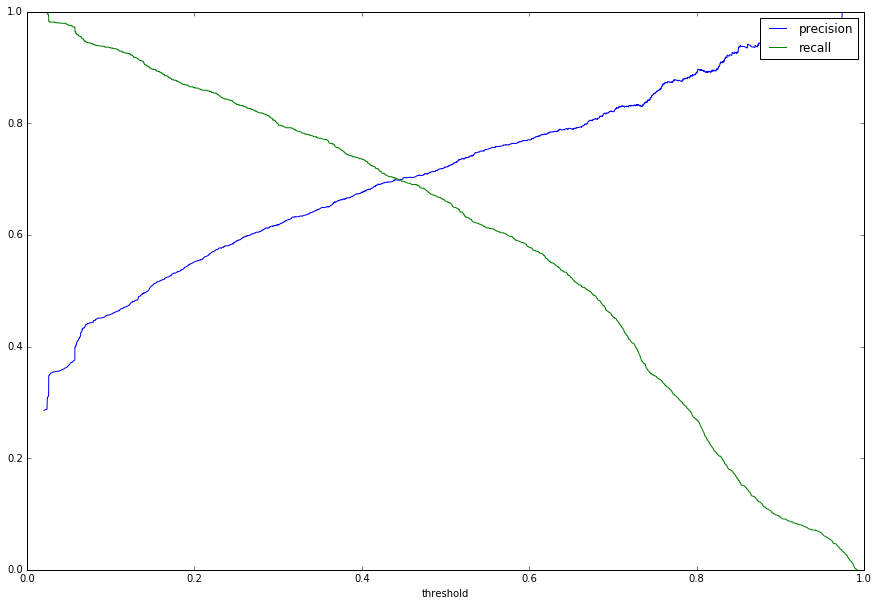

In [27]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresh = precision_recall_curve(y_test, pred)

plt.plot(thresh, prec[:-1], label="precision")
plt.plot(thresh, rec[:-1], label="recall")
plt.xlabel("threshold")
plt.legend()

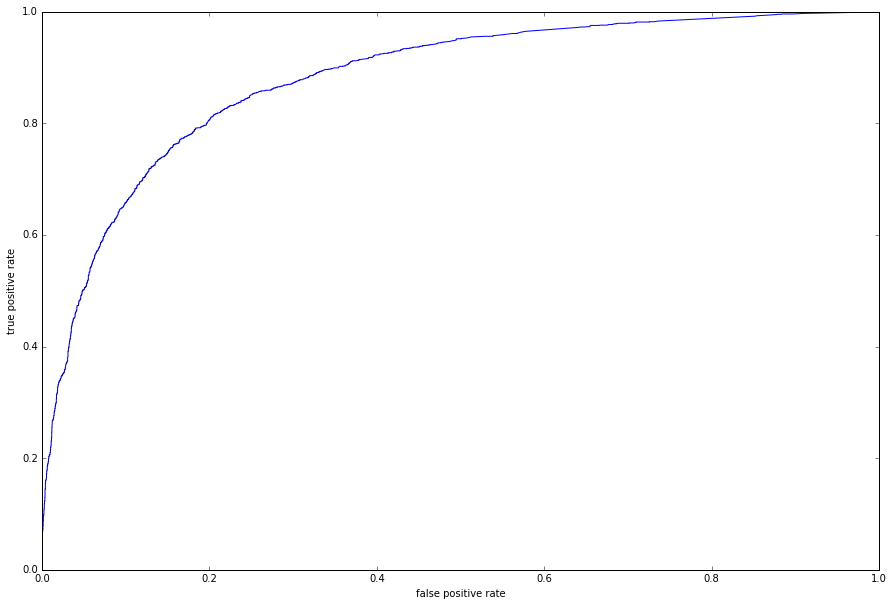

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thr = roc_curve(y_test, pred)
plt.plot(fpr, tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [30]:
def get_distance(fpr, tpr):
    return ((fpr) ** 2 + (tpr - 1) ** 2) ** 0.5

def get_opt_thresh(actual, predicted):
    fprs, tprs, thrs = roc_curve(actual, predicted)

    fpr_opt = None
    tpr_opt = None
    distance_opt = None
    thr_opt = None
    for i in range(len(thrs)):
        dist = get_distance(fprs[i], tprs[i])
        if (distance_opt is None) or (dist < distance_opt):
            distance_opt = dist
            fpr_opt = fprs[i]
            tpr_opt = tprs[i]
            thr_opt = thrs[i]
    
    return thr_opt

In [34]:
opt_tresh = get_opt_thresh(y_test, pred)
opt_tresh

0.28575838

In [35]:
clf = xgb.XGBClassifier()
clf.fit(x, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [36]:
pred_test = clf.predict_proba(test)[:,1]
pred_test

array([ 0.12128125,  0.02764105,  0.58164448, ...,  0.05884574,
        0.22698607,  0.02749419], dtype=float32)

In [37]:
pred_test_ = [1 if p > 0.297 else 0 for p in pred_test]

In [38]:
submission = pd.DataFrame()
submission['target'] = pred_test_
submission.to_csv("submission_xgb_1.csv", index=False, header=False)